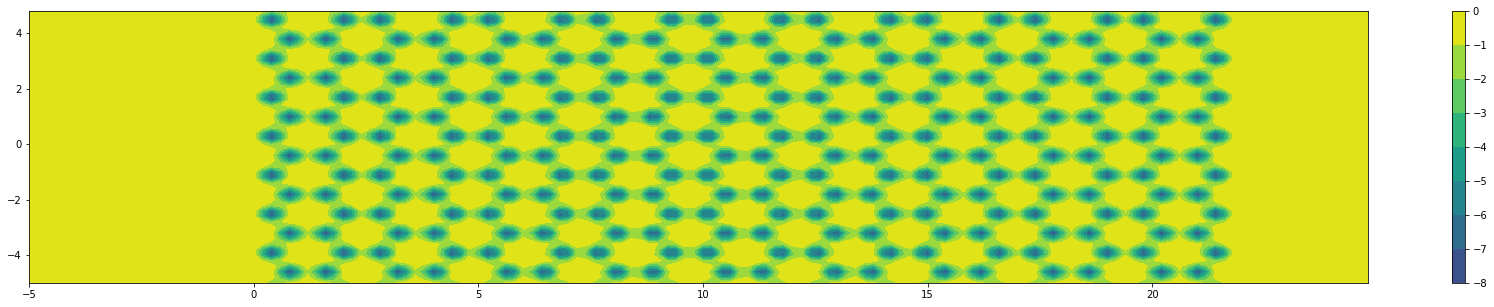

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# PRL 119, 253904 (2017)
#https://doi.org/10.1103/PhysRevLett.119.253904

a = 1.4 #lattice constant
b = a/np.sqrt(3)
uc_pillars = [(0,0),       (0.5*b, 0.5*np.sqrt(3)*b), 
             (1.5*b,0.5*np.sqrt(3)*b), (2*b,0)] 
             #4 pillars' coordinates in the rectangular unit cell
cell_width = np.sqrt(3)*a
cell_height = a

def principaly(y):
    return np.abs(cell_height*(y/cell_height-np.floor(y/cell_height)))

def pillar(coord,pillarindex):
    x,y = coord
    i,j = pillarindex
    ym = j*cell_height + uc_pillars[i%4][1]             + a/np.sqrt(24)
    xm = np.floor(i/4)*cell_width + uc_pillars[i%4][0]  + a/np.sqrt(12)
    
    p=8
    d=.25
    return -p*np.exp(-((x-xm)**2+(y-ym)**2)/d**2)

def R(x,y):
    total = 0
    y = principaly(y)
    for i in np.arange(0,len(uc_pillars)*9):
        total += pillar( (x,y) , pillarindex=(i,0) )
    return total

vR = np.vectorize(R)
x_ = np.arange(-5, 25, 0.2)
y_ = np.arange(-5, 5, 0.2)
x_, y_ = np.meshgrid(x_, y_)

r_ = vR(x_,y_)

plt.figure(figsize=(30,5))
h = plt.contourf(x_, y_, r_)

plt.colorbar()
plt.clim(-10,0)
plt.show()

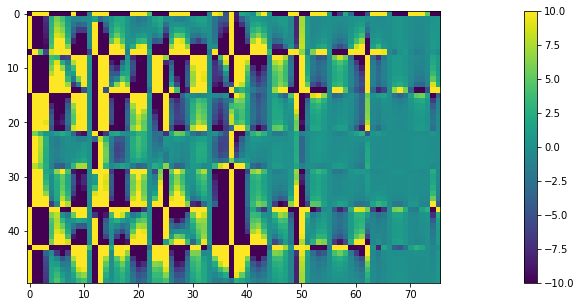

In [6]:
from scipy.fft import *

r_tilde = rfft2(r_)

plt.figure(figsize=(30,5))
h = plt.imshow(np.real((r_tilde)))
plt.colorbar()
plt.clim(-10,10)